In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings("ignore")

In [90]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%m/%d/%Y %H:%M:%S')
# df = pd.read_csv("Microsoft_Stock.csv", parse_dates=['Date'], index_col='Date', date_parser=dateparse)
df = pd.read_csv("Microsoft_Stock.csv")

In [82]:
df.head()

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438


In [6]:
for i in df.columns:
    print("The number of NaA in {} is {}".format(i, df[i].isnull().sum()))

The number of NaA in Open is 0
The number of NaA in High is 0
The number of NaA in Low is 0
The number of NaA in Close is 0
The number of NaA in Volume is 0


In [84]:
df.Date = pd.to_datetime(df.Date, format='%m/%d/%Y %H:%M:%S')

In [93]:
df.Date = pd.to_datetime(df.Date, format='%m/%d/%Y %H:%M:%S').dt.normalize()

In [95]:
df.index = df.Date

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2015-04-01 to 2021-03-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1511 non-null   datetime64[ns]
 1   Open    1511 non-null   float64       
 2   High    1511 non-null   float64       
 3   Low     1511 non-null   float64       
 4   Close   1511 non-null   float64       
 5   Volume  1511 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 82.6 KB


In [25]:
df.shape

(1511, 6)

In [97]:
df.head()

,Date,Open,High,Low,Close,Volume
Date,,,,,,
2015-04-01,2015-04-01,40.60,40.76,40.31,40.72,36865322
2015-04-02,2015-04-02,40.66,40.74,40.12,40.29,37487476
2015-04-06,2015-04-06,40.34,41.78,40.18,41.55,39223692
2015-04-07,2015-04-07,41.61,41.91,41.31,41.53,28809375
2015-04-08,2015-04-08,41.48,41.69,41.04,41.42,24753438


In [98]:
train = df.iloc[:1000]
test = df.iloc[1000:]

In [25]:
test.iloc[0]

Open           119.50
High           119.59
Low            117.04
Close          117.05
Volume    33624528.00
Name: 2019-03-22 16:00:00, dtype: float64

In [106]:
test

,Date,Open,High,Low,Close,Volume
Date,,,,,,
2019-03-22,2019-03-22,119.50,119.59,117.04,117.05,33624528
2019-03-25,2019-03-25,116.56,118.01,116.32,117.66,27067117
2019-03-26,2019-03-26,118.62,118.71,116.85,117.91,26097665
2019-03-27,2019-03-27,117.88,118.21,115.52,116.77,22733427
2019-03-28,2019-03-28,117.44,117.58,116.13,116.93,18334755
...,...,...,...,...,...,...
2021-03-25,2021-03-25,235.30,236.94,231.57,232.34,34061853
2021-03-26,2021-03-26,231.55,236.71,231.55,236.48,25479853
2021-03-29,2021-03-29,236.59,236.80,231.88,235.24,25227455


## Predict "Close"

In [129]:
ts_close = train.Close
ts_close_test = test.Close

In [100]:
# check the stationary of data
ts_adf = ADF(ts_close.tolist())
ts_adf

(0.5288526561196594,
 0.9857241627059556,
 8,
 991,
 {'1%': -3.4369658620871286,
  '5%': -2.8644609013346485,
  '10%': -2.56832523159495},
 3011.1566535806032)

In [101]:
ts_close_diff1 = ts_close.diff(1)
ts_close_diff1 = ts_close_diff1.fillna(0)
ts_adf_diff1 = ADF(ts_close_diff1.tolist())
ts_adf_diff1

(-13.011964942687296,
 2.5567830115531918e-24,
 7,
 992,
 {'1%': -3.436959175494265,
  '5%': -2.8644579524531975,
  '10%': -2.568323660940752},
 3009.881198899161)

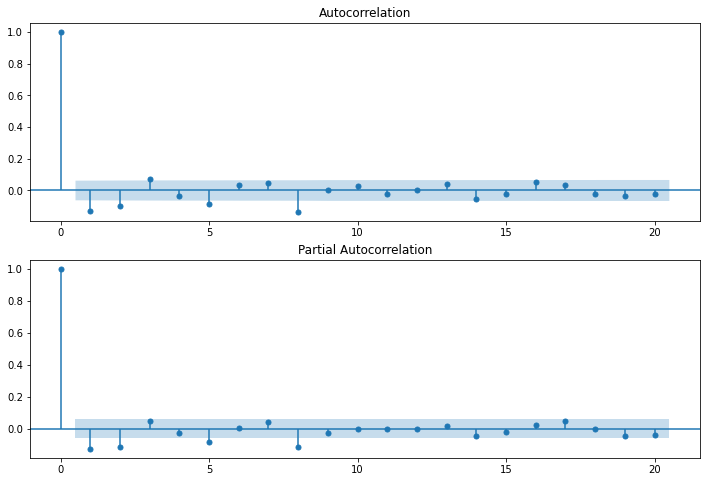

In [102]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211) 
sm.graphics.tsa.plot_acf(ts_close_diff1, lags=20, ax=ax1) 
ax2 = fig.add_subplot(212) 
sm.graphics.tsa.plot_pacf(ts_close_diff1, lags=20, ax=ax2) 
plt.show()

In [32]:
train_results = sm.tsa.arma_order_select_ic(ts_close, ic=['aic', 'bic'], trend='nc', max_ar=4, max_ma=4)

print('AIC', train_results.aic_min_order)
print('BIC', train_results.bic_min_order)

AIC (4, 2)
BIC (1, 1)


In [166]:
## AR(p=2)
model = sm.tsa.ARIMA(ts_close, order=(1, 1, 1))
model_fit = model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54559D+00    |proj g|=  3.97260D-04

At iterate    5    f=  1.54558D+00    |proj g|=  1.11235D-03

At iterate   10    f=  1.54557D+00    |proj g|=  9.13936D-04

At iterate   15    f=  1.54557D+00    |proj g|=  2.22045D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     26      1     0     0   4.441D-08   1.546D+00
  F =   1.5455654237685270     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


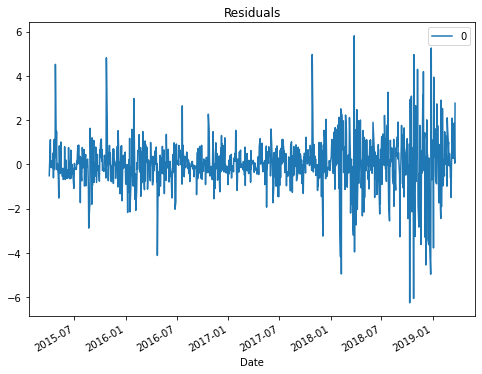

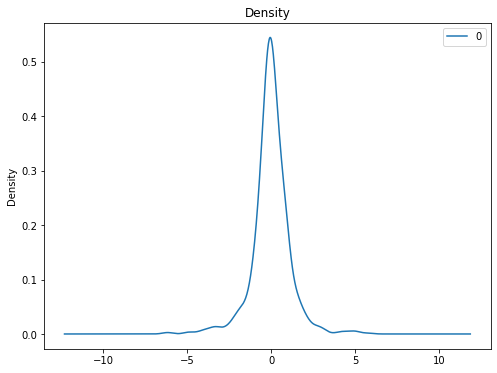

In [167]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
# fig, ax = plt.subplots(1,2)
fig1, ax1 = plt.subplots(figsize=(8,6))
residuals.plot(title="Residuals", ax=ax1)
fig2, ax2 = plt.subplots(figsize=(8,6))
residuals.plot(kind='kde', title='Density', ax=ax2)
plt.show()

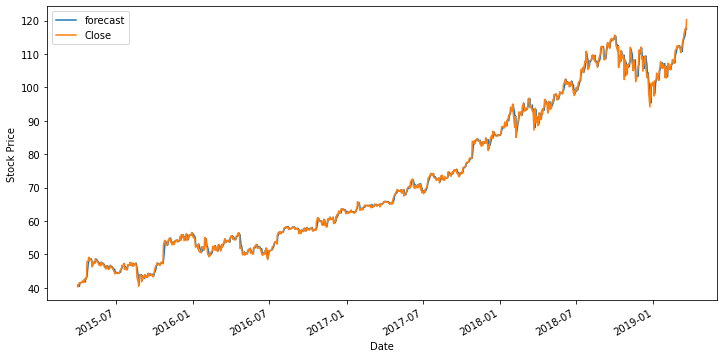

In [168]:
fig3, ax3 = plt.subplots(figsize=(12,6))
model_fit.plot_predict(dynamic=False, ax=ax3)
plt.ylabel("Stock Price")
plt.show()

In [115]:
ts_close_test.index

DatetimeIndex(['2019-03-22', '2019-03-25', '2019-03-26', '2019-03-27',
               '2019-03-28', '2019-03-29', '2019-04-01', '2019-04-02',
               '2019-04-03', '2019-04-04',
               ...
               '2021-03-18', '2021-03-19', '2021-03-22', '2021-03-23',
               '2021-03-24', '2021-03-25', '2021-03-26', '2021-03-29',
               '2021-03-30', '2021-03-31'],
              dtype='datetime64[ns]', name='Date', length=511, freq=None)

In [110]:
ts_close_test.index[-1]

Timestamp('2021-03-31 00:00:00')

In [121]:
start_idx = pd.datetime(2019, 3, 22)
end_idx = pd.datetime(2021, 3, 31)

In [144]:
ts_close_test.values

array([117.05, 117.66, 117.91, 116.77, 116.93, 117.94, 119.02, 119.19,
       119.97, 119.36, 119.89, 119.93, 119.28, 120.19, 120.33, 120.95,
       121.05, 120.77, 121.77, 123.37, 123.76, 125.44, 125.01, 129.15,
       129.89, 129.77, 130.6 , 127.88, 126.21, 128.9 , 128.15, 125.52,
       125.51, 125.5 , 127.13, 123.35, 124.73, 126.02, 128.93, 128.07,
       126.22, 126.9 , 127.67, 126.18, 126.24, 126.16, 124.94, 125.73,
       123.68, 119.84, 123.16, 125.83, 127.82, 131.4 , 132.6 , 132.1 ,
       131.49, 132.32, 132.45, 132.85, 135.16, 135.69, 136.95, 136.97,
       137.78, 133.43, 133.93, 134.15, 133.96, 135.68, 136.58, 137.46,
       137.06, 136.96, 136.46, 137.85, 138.4 , 138.9 , 138.9 , 137.08,
       136.27, 136.42, 136.62, 138.43, 139.29, 140.72, 140.19, 141.34,
       141.03, 140.35, 136.27, 138.06, 136.9 , 132.21, 134.69, 135.28,
       138.89, 137.71, 135.79, 138.6 , 133.98, 133.68, 136.13, 138.41,
       137.26, 138.79, 137.78, 133.39, 135.45, 135.74, 135.56, 138.12,
      

In [171]:
predict = model_fit.forecast(steps=511, alpha=0.05)[0]

In [172]:
predict[-10:]

array([158.71627463, 158.79484852, 158.87342242, 158.95199632,
       159.03057021, 159.10914411, 159.187718  , 159.2662919 ,
       159.3448658 , 159.42343969])

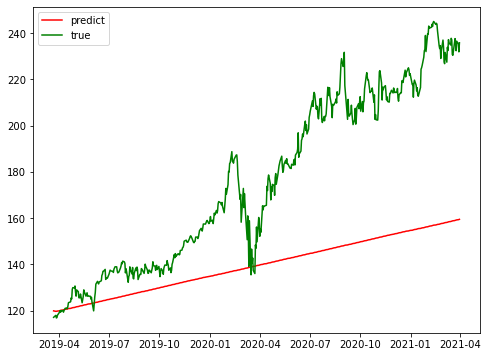

In [174]:
plt.figure(figsize=(8,6))
plt.plot(ts_close_test.index, predict, label='predict', color='red')
plt.plot(ts_close_test.index, ts_close_test.values, label='true', color='green')
plt.legend()
plt.show()

In [179]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.tsa.seasonal import STL

In [180]:
# result = STL(ts_close, period=12).fit()
# result.plot()
# plt.show()